In [ ]:
from google.colab import drive


Mounted at /content/gdrive


In [ ]:
import json
import math
import os

import cv2
from PIL import Image
import numpy as np
from keras import layers
from tensorflow.keras.applications import ResNet50,MobileNet, DenseNet201, InceptionV3, NASNetLarge, InceptionResNetV2, NASNetMobile
from keras.callbacks import Callback, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score, accuracy_score
import scipy
from tqdm import tqdm
import tensorflow as tf
from keras import backend as K
import gc
from functools import partial
from sklearn import metrics
from collections import Counter
import json
import itertools


%matplotlib inline

In [ ]:
def Dataset_loader(DIR, RESIZE, sigmaX=10):
    IMG = []
    read = lambda imname: np.asarray(Image.open(imname).convert("RGB"))
    for IMAGE_NAME in tqdm(os.listdir(DIR)):
        PATH = os.path.join(DIR,IMAGE_NAME)
        _, ftype = os.path.splitext(PATH)
        if ftype == ".png" or ".tif":
            img = read(PATH)
           
            img = cv2.resize(img, (RESIZE,RESIZE))
           
            IMG.append(np.array(img))
    return IMG

benign_train = np.array(Dataset_loader('/content/gdrive/MyDrive/dataset/Benign',128))
malign_train = np.array(Dataset_loader('/content/gdrive/MyDrive/dataset/Malignant/ductal_carcinoma',128))
#benign_test = np.array(Dataset_loader('/content/gdrive/MyDrive/BreakHis/Benign_test',128))
#malign_test = np.array(Dataset_loader('/content/gdrive/MyDrive/BreakHis/Malign_test',128))

100%|█████████▉| 444/445 [00:07<00:00, 57.12it/s]


IsADirectoryError: ignored

In [ ]:
benign_label=np.zeros(len(benign_train))
malign_label=np.ones(len(malign_train))

In [ ]:
print(len(benign_train),len(malign_train))

2401 5437


In [ ]:
x=np.concatenate((benign_train,malign_train), axis=0)
y=np.concatenate((benign_label,malign_label), axis=0)

from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test=train_test_split(x,y,test_size=0.33, random_state=11)

In [ ]:
s=np.arange(x_train.shape[0])
np.random.shuffle(s)
x_train=x_train[s]
y_train=y_train[s]

s=np.arange(x_test.shape[0])
np.random.shuffle(s)
x_test=x_test[s]
y_test=y_test[s]

y_train=to_categorical(y_train, num_classes=2)
y_test=to_categorical(y_test, num_classes=2)

In [ ]:
print(len(x_train),len(x_test))

5251 2587


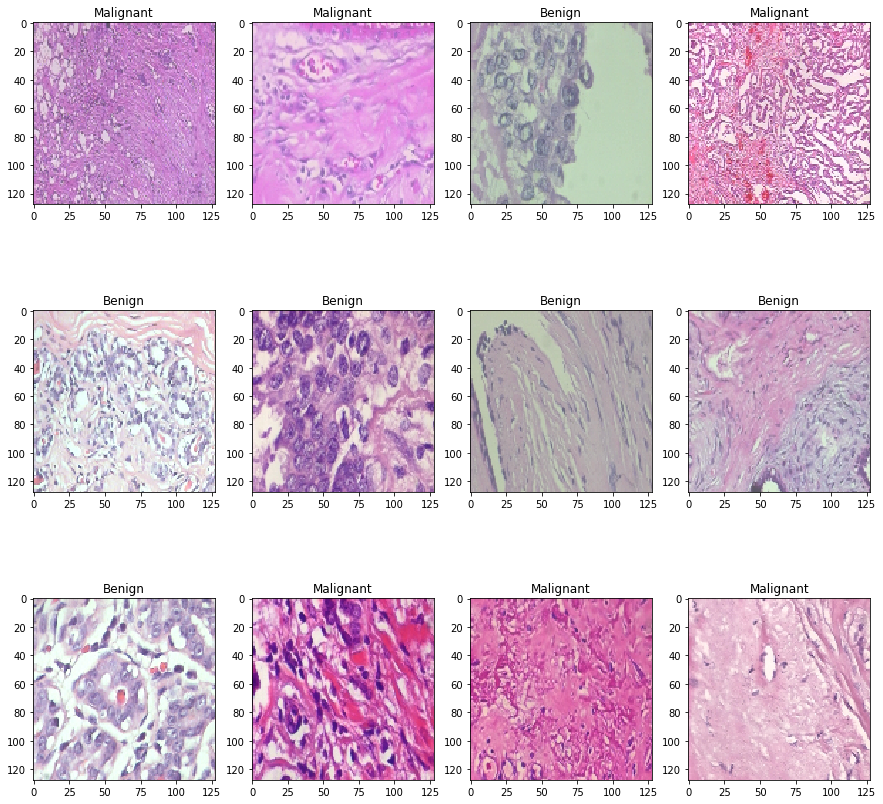

In [ ]:
w=60
h=40
fig=plt.figure(figsize=(15, 15))
columns = 4
rows = 3

for i in range(1, columns*rows +1):
    ax = fig.add_subplot(rows, columns, i)
    if np.argmax(y_train[i]) == 0:
        ax.title.set_text('Benign')
    else:
        ax.title.set_text('Malignant')
    plt.imshow(x_train[i], interpolation='nearest')
plt.show()

In [ ]:
BATCH_SIZE = 48

train_generator = ImageDataGenerator(
        zoom_range=2,  
        rotation_range = 90,
        horizontal_flip=True,
        vertical_flip=True,  
    )

In [ ]:
def build_model():
    model = Sequential()
    model.add(DenseNet201(weights='imagenet',include_top=False,input_shape=(128,128,3)))
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dropout(0.5))
    model.add(layers.BatchNormalization())
    
    model.compile(
        loss= 'categorical_crossentropy',
        optimizer='adam',
        metrics=['accuracy']
    )
    
    return model

In [ ]:
K.clear_session()
gc.collect()



model = build_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet201 (Functional)     (None, 4, 4, 1920)        18321984  
_________________________________________________________________
global_average_pooling2d (Gl (None, 1920)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1920)              0         
_________________________________________________________________
batch_normalization (BatchNo (None, 1920)              7680      
Total params: 18,329,664
Trainable params: 18,096,768
Non-trainable params: 232,896
_________________________________________________________________


In [ ]:
learn_control = ReduceLROnPlateau(monitor='val_accuracy', patience=5,
                                  verbose=1,factor=0.2, min_lr=1e-7)

filepath="/content/gdrive/MyDrive/weights.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

In [ ]:
x_val = x_test
y_val = y_test

In [ ]:
history = model.fit(
    train_generator.flow(x_train, y_train, batch_size=BATCH_SIZE),
    steps_per_epoch=x_train.shape[0] / BATCH_SIZE,
    epochs=15,
    validation_data=(x_val, y_val),
    callbacks=[learn_control, checkpoint]
)

Epoch 1/15
109/109 [==============================] - 101s 858ms/step - loss: 0.2919 - accuracy: 0.8795 - val_loss: 7.4998 - val_accuracy: 0.8705

Epoch 00001: val_accuracy did not improve from 0.88249
Epoch 2/15
109/109 [==============================] - 80s 728ms/step - loss: 0.2890 - accuracy: 0.8789 - val_loss: 5.2263 - val_accuracy: 0.8755

Epoch 00002: val_accuracy did not improve from 0.88249
Epoch 3/15
109/109 [==============================] - 80s 726ms/step - loss: 0.2885 - accuracy: 0.8836 - val_loss: 7.0123 - val_accuracy: 0.8724

Epoch 00003: val_accuracy did not improve from 0.88249
Epoch 4/15
109/109 [==============================] - 80s 727ms/step - loss: 0.2869 - accuracy: 0.8787 - val_loss: 6.3219 - val_accuracy: 0.8736

Epoch 00004: val_accuracy did not improve from 0.88249
Epoch 5/15
109/109 [==============================] - 80s 728ms/step - loss: 0.2931 - accuracy: 0.8791 - val_loss: 4.6117 - val_accuracy: 0.8775

Epoch 00005: val_accuracy did not improve from 0.

In [ ]:
features_train = model.predict(x_train)
features_val = model.predict(x_val)
features_test = model.predict(x_test)

print(features_train.shape,features_val.shape,features_test.shape)

(5251, 1920) (2587, 1920) (2587, 1920)


In [ ]:
from sklearn.svm import SVC
svm = SVC(kernel='rbf')
classifier = svm.fit(features_train,np.argmax(y_train,axis=1))

In [ ]:
svm.score(features_train,np.argmax(y_train,axis=1))

0.88402209103028

In [ ]:
svm.score(features_val,np.argmax(y_val,axis=1))

0.8658678005411674

In [ ]:
svm.score(features_test,np.argmax(y_test,axis=1))

0.8658678005411674

In [ ]:
predictions = svm.predict(features_test)

In [ ]:

data=np.array(x_test)
x_test=data.reshape(a,1920)
print(x_test.shape)


ValueError: ignored

In [ ]:
from sklearn.metrics import plot_confusion_matrix

disp=plot_confusion_matrix(svm,x_test,y_test,cmap='Blues',values_format='.3g')


ValueError: ignored